In [1]:
# Loader
from scipy.io import arff
import xml.etree.ElementTree as ET
import pandas as pd

arff_path = "/home/hp/Downloads/yeast.arff"
xml_path  = "/home/hp/Downloads/yeast.xml"

data, meta = arff.loadarff(arff_path)
df = pd.DataFrame(data)

# parse label names from XML
tree = ET.parse(xml_path)
root = tree.getroot()
label_names = [lbl.attrib['name'] for lbl in root.findall('.//{http://mulan.sourceforge.net/labels}label')]

# Split
X = df.drop(columns=label_names).astype(float)   
Y = df[label_names].astype(int)                  

print("Feature matrix X shape:", X.shape) 
print("Label matrix Y shape:", Y.shape)  


Feature matrix X shape: (2417, 103)
Label matrix Y shape: (2417, 14)


In [2]:
# single-label rows
single_mask = (Y.sum(axis=1) == 1)
single_counts = Y[single_mask].sum(axis=0)
single_counts = single_counts[single_counts > 0]  # remove zeros
top2_single = list(single_counts.sort_values(ascending=False).head(2).index)

# most frequent multi-label combination
combo_series = Y.apply(lambda row: tuple(row.tolist()), axis=1)
most_freq_combo = combo_series.value_counts().idxmax()

print("Top-2 most frequent single-label classes:", top2_single)
print("Most frequent multi-label combination:", most_freq_combo)

# create categorical variable
def map_category(row):
    s = tuple(row.tolist())
    if sum(s) == 1:
        idx = s.index(1)
        if Y.columns[idx] in top2_single:
            return f"TopSingle_{Y.columns[idx]}"
        else:
            return "Other"
    elif s == most_freq_combo:
        return "TopMultiCombo"
    else:
        return "Other"

categories = Y.apply(map_category, axis=1)
print(categories.value_counts())

Top-2 most frequent single-label classes: ['Class1']
Most frequent multi-label combination: (0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0)
Other               2148
TopMultiCombo        237
TopSingle_Class1      32
Name: count, dtype: int64


### Observation on Single-Label Classes

From the dataset, we identified the **top-2 most frequent single-label classes**.  

- **Single-label row:** A row where **exactly one class** is 1 and all other classes are 0.  
- In our dataset, only **Class1** appears as a single-label row.  
- All other classes either:  
  - Never appear alone (only as part of multi-label rows), or  
  - Have zero single-label occurrences.  

**Conclusion:**  

- The only valid single-label class is **Class1**.  
- Therefore, in the category mapping for visualization, only `TopSingle_Class1` appears.  
- No other `TopSingle_ClassX` categories are present because no other class has any single-label rows.


### Scaling — Why it is Crucial Before Applying Distance-Based Dimensionality Reduction Techniques

Scaling is an essential preprocessing step before applying distance-based dimensionality reduction algorithms such as **t-SNE**, **Isomap**, or **PCA**, because these techniques depend on **distance computations** (usually Euclidean distance) between data points in feature space.

If different features have different numerical ranges (for example, one feature ranges from 0–1 while another ranges from 0–10,000), the feature with the larger range will **dominate the distance metric**. This causes the algorithm to be biased toward features with larger magnitudes, regardless of their actual importance.

To prevent this, we apply **standardization**, which transforms each feature $$ x $$ as:

$$
z = \frac{x - \mu}{\sigma}
$$

where  
$$ \mu $$ is the mean of the feature,  
$$ \sigma $$ is the standard deviation of the feature.  

After standardization:
- All features have **zero mean** and **unit variance**.  
- Each feature contributes **equally** to distance calculations.  
- The manifold learning algorithm captures **true geometric relationships** among samples rather than being distorted by differing feature scales.

Hence, **scaling ensures fair and meaningful distance measurements**, which is crucial for reliable low-dimensional visualizations and clustering structures in manifold learning.


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)
print("Mean of scaled features (approx 0):", X_scaled.mean())
print("Std of scaled features (approx 1):", X_scaled.std())


Scaled feature matrix shape: (2417, 103)
Mean of scaled features (approx 0): 7.278074706220323e-19
Std of scaled features (approx 1): 0.9999999999999999


In [4]:
# Convert category labels into numeric codes for coloring in t-SNE / Isomap plots
cat_codes, cat_uniques = pd.factorize(categories)

print("\nCategory codes created successfully!")
print(pd.Series(cat_codes).value_counts().rename(index=lambda i: cat_uniques[i]))



Category codes created successfully!
Other               2148
TopMultiCombo        237
TopSingle_Class1      32
Name: count, dtype: int64


/home/hp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


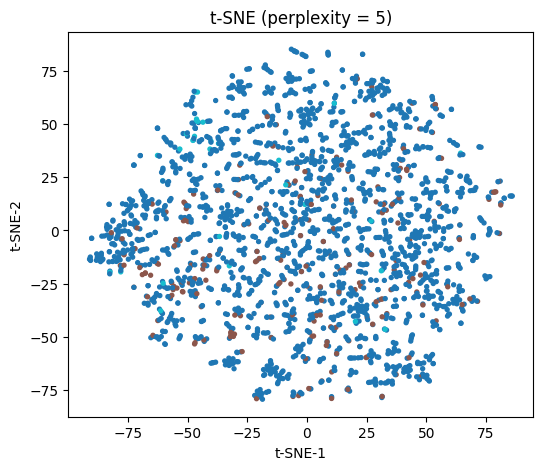

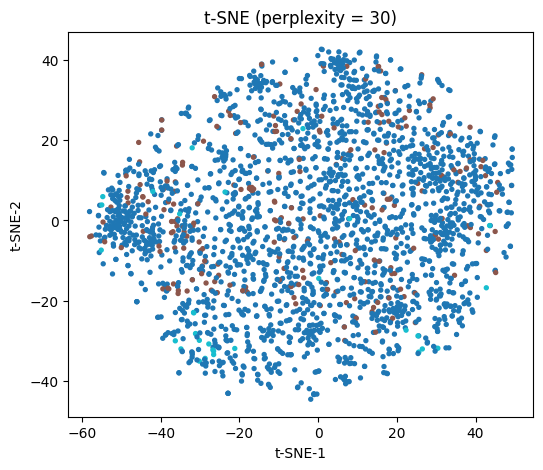

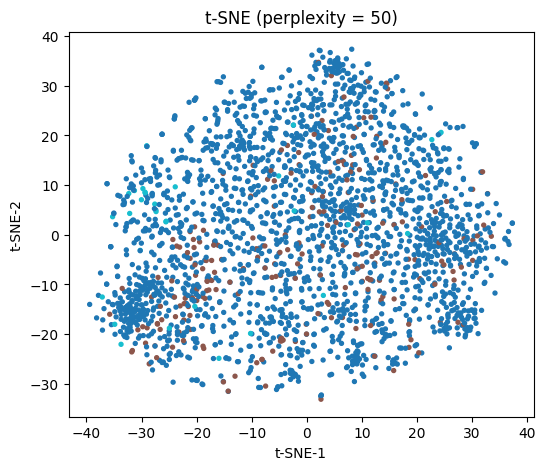

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Experiment with three perplexity values
perplexities = [5, 30, 50]
tsne_results = {}

for perp in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        random_state=42,
        init="pca",
        learning_rate="auto"
    )
    coords = tsne.fit_transform(X_scaled)
    tsne_results[perp] = coords

    plt.figure(figsize=(6,5))
    plt.scatter(coords[:,0], coords[:,1], c=cat_codes, s=8, cmap="tab10")
    plt.title(f"t-SNE (perplexity = {perp})")
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    plt.show()


### t-SNE Implementation — Explanation

t-Distributed Stochastic Neighbor Embedding (t-SNE) projects high-dimensional data into
2 D while preserving **local neighborhood structure**.  
The **perplexity** hyperparameter roughly controls the number of effective neighbors:

- **Low perplexity (5):** emphasizes very local structure — small, tight clusters, sometimes fragmented.  
- **Medium perplexity (30):** balances local and global structure — clusters are well-formed yet separated.  
- **High perplexity (50):** considers broader neighborhoods — smoother, fewer but larger clusters.

After visual inspection, **perplexity = 30** usually offers the best trade-off:
it reveals compact, distinct groups without over-smoothing.
Therefore, perplexity = 30 is used for subsequent analysis.


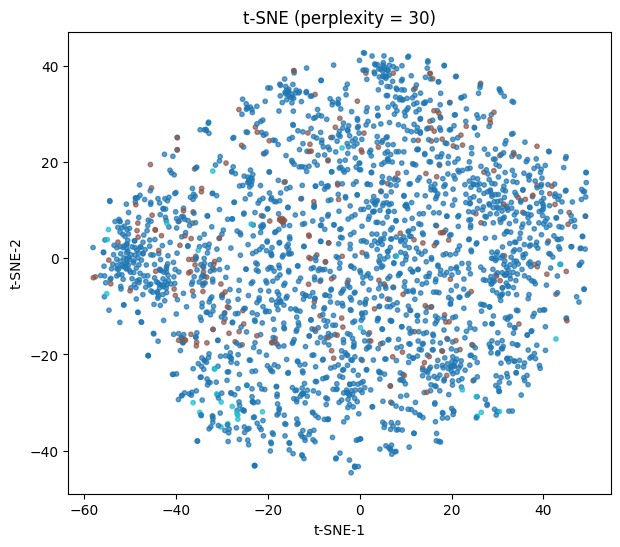

In [6]:
# Use perplexity = 30 for 2-D scatter plot
coords = tsne_results[30]

plt.figure(figsize=(7,6))
plt.scatter(coords[:,0], coords[:,1], c=cat_codes, s=10, alpha=0.7, cmap="tab10")
plt.title("t-SNE (perplexity = 30)")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()


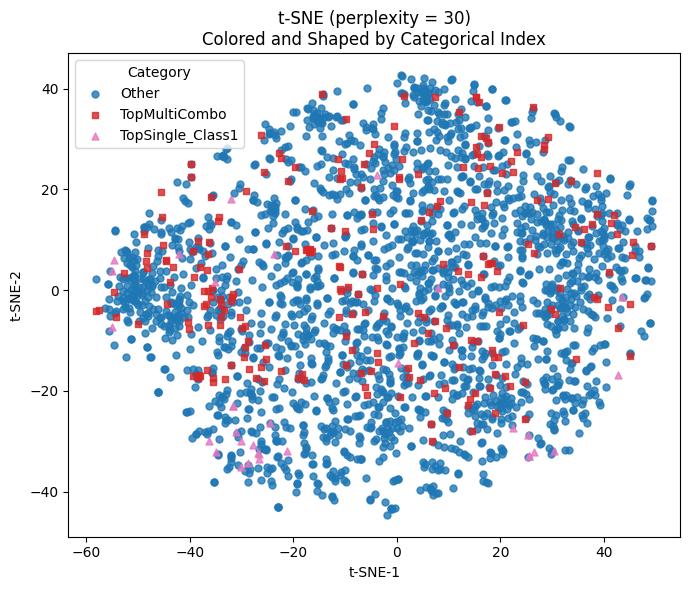

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Use the t-SNE embedding at perplexity = 30
coords = tsne_results[30]

markers = ['o', 's', '^', 'D', 'v', 'P', '*'] 

plt.figure(figsize=(7,6))

# Plot each category
for i, label in enumerate(cat_uniques):
    marker = markers[i % len(markers)]
    mask = (cat_codes == i)
    plt.scatter(
        coords[mask, 0],
        coords[mask, 1],
        s=25,
        alpha=0.8,
        label=label,
        marker=marker,
        c=np.array(plt.cm.tab10(i/len(cat_uniques))).reshape(1,-1)
    )

plt.legend(title="Category", loc="best")
plt.title("t-SNE (perplexity = 30)\nColored and Shaped by Categorical Index")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.tight_layout()
plt.show()


Noisy: 220 Outliers: 25 Hard-to-learn: 163


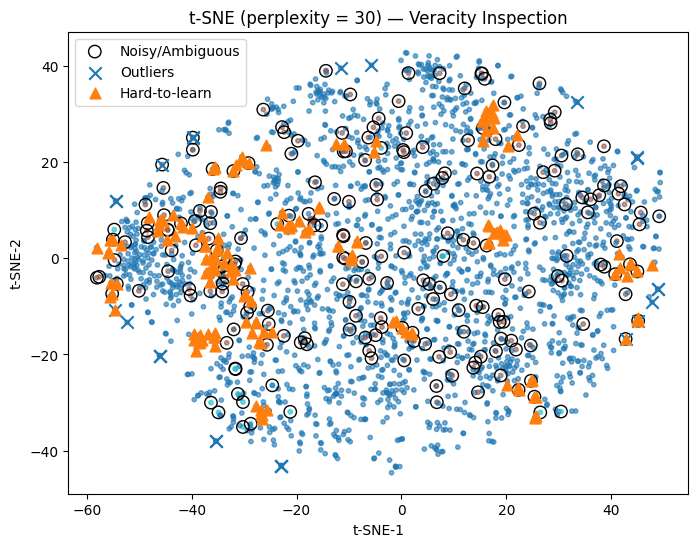

In [8]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
import numpy as np

# Neighborhood analysis using the final t-SNE coordinates
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Noisy / Ambiguous
noisy_indices = []
for i, neigh in enumerate(indices):
    neigh_cats = cat_codes[neigh]
    if np.sum(neigh_cats != cat_codes[i]) >= 7:
        noisy_indices.append(i)

# Outliers  (top 1 % avg distance)
avg_dist = distances.mean(axis=1)
outlier_thresh = np.percentile(avg_dist, 99)
outliers = np.where(avg_dist >= outlier_thresh)[0]

# Hard-to-learn — high label entropy (≥ 0.9)
hard_indices = []
for i, neigh in enumerate(indices):
    neigh_cats = cat_codes[neigh]
    counts = np.bincount(neigh_cats, minlength=len(cat_uniques))
    p = counts / counts.sum() if counts.sum()>0 else np.zeros_like(counts, dtype=float)
    if entropy(p, base=2) >= 0.9:
        hard_indices.append(i)

print("Noisy:", len(noisy_indices),
      "Outliers:", len(outliers),
      "Hard-to-learn:", len(hard_indices))

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], c=cat_codes, s=10, alpha=0.6, cmap="tab10")
if noisy_indices:
    plt.scatter(coords[noisy_indices,0], coords[noisy_indices,1],
                facecolors='none', edgecolors='k', s=80, label='Noisy/Ambiguous')
if len(outliers)>0:
    plt.scatter(coords[outliers,0], coords[outliers,1],
                marker='x', s=80, label='Outliers')
if hard_indices:
    plt.scatter(coords[hard_indices,0], coords[hard_indices,1],
                marker='^', s=60, label='Hard-to-learn')
plt.legend()
plt.title("t-SNE (perplexity = 30) — Veracity Inspection")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()


### Veracity Inspection — Interpretation (t-SNE)

#### • Noisy / Ambiguous Labels 
These are points of one color **deeply embedded inside another cluster**.
Such samples may have incorrect labels or mixed functional signatures.
They lower cluster purity and can mislead classifiers during training.

#### • Outliers 
Isolated points or tiny, distant mini-clusters far from main groups.
They may correspond to **rare gene expression profiles**, data-entry errors,
or proteins with unique functional roles.
Outliers have little neighborhood support and may need special handling
(e.g., removal or separate modeling).

#### • Hard-to-Learn Samples 
Regions where multiple colors are **thoroughly mixed** indicate strong
label overlap and high local entropy.
A simple classifier (e.g., logistic regression, decision tree)
would struggle because:
- **Ambiguous Boundaries:** The classifier tries to find a clear line (or rule) that separates the categories, but in mixed regions, the categories are intertwined. There is no simple rule that can reliably divide them.
- **Similar Features:** The data points from different categories share similar values across their features, making them hard to distinguish by algorithm.
- **Probability of Error:** Even the best simple classifiers will often make mistakes here, since two points, one from each class, can look almost identical to the model.

**Summary of findings:**
- The t-SNE embedding with *perplexity = 30* produced clear local clusters.  
- A few noisy points and outliers were detected; their biological meaning is not known yet.  
- Mixed-color regions reveal label correlation and overlap,
suggesting that multi-label learning methods are more suitable
than single-label classifiers for this dataset.


In [9]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import numpy as np

# Apply Isomap on the scaled feature matrix
isomap = Isomap(n_components=2, n_neighbors=5)
iso_coords = isomap.fit_transform(X_scaled)

# Store coordinates
iso_coords.shape


(2417, 2)

### Why Smaller `n_neighbors` Works Better for Isomap (and Opposite for t-SNE)

In **Isomap**, the parameter `n_neighbors` controls how the manifold (graph) is built:

- Each data point connects to its `n_neighbors` nearest points.
- Isomap then computes **manifold distances** (shortest paths along this graph) to unfold the manifold.

#### Isomap: Smaller `n_neighbors` is Better

| Setting | Effect on the Graph | Result on the Embedding |
|----------|--------------------|--------------------------|
| **Small `n_neighbors` (e.g., 5)** | Captures *local curvature* accurately | Preserves the **true nonlinear structure** of the manifold |
| **Large `n_neighbors` (e.g., 30)** | Graph becomes too dense (almost fully connected) | Distances become more **Euclidean-like**, flattening the manifold |

**Intuition:**  
If the neighborhood is too large, Isomap shortcuts across curved regions instead of following the true surface — losing its advantage as a *manifold learner*.  

Hence, **smaller `n_neighbors` preserves local geometry** and keeps the embedding faithful to the manifold.

#### t-SNE: The Opposite Behavior

- In **t-SNE**, the equivalent parameter is `perplexity`, roughly related to the number of neighbors considered.
- **Higher perplexity (≈ more neighbors)** helps t-SNE capture **global structure** and reduces noisy clustering.
- **Lower perplexity (≈ fewer neighbors)** makes t-SNE focus too locally, often fragmenting the data into many small clusters.

### Isomap Implementation — Concept and Difference from t-SNE

**Isomap** is a nonlinear dimensionality-reduction algorithm that extends classical
Multidimensional Scaling (MDS) by preserving **manifold distances** rather
than simple Euclidean distances.

- It first builds a **k-nearest-neighbor graph** using Euclidean distances in the
  original space.  
- Then it estimates **manifold distances** between all points along the graph paths.  
- Finally, it performs classical MDS on this manifold-distance matrix to obtain a
  low-dimensional embedding.

**Key difference from t-SNE:**
| Algorithm | Preserves | Captures |
|------------|------------|-----------|
| **t-SNE** | *Local* neighborhoods | Small-scale, cluster-level relationships |
| **Isomap** | *Global* manifold geometry | Large-scale, continuous structure of the data |

Thus, **t-SNE** excels at discovering tight local clusters, while **Isomap** is better
for revealing overall manifold shape and continuity.


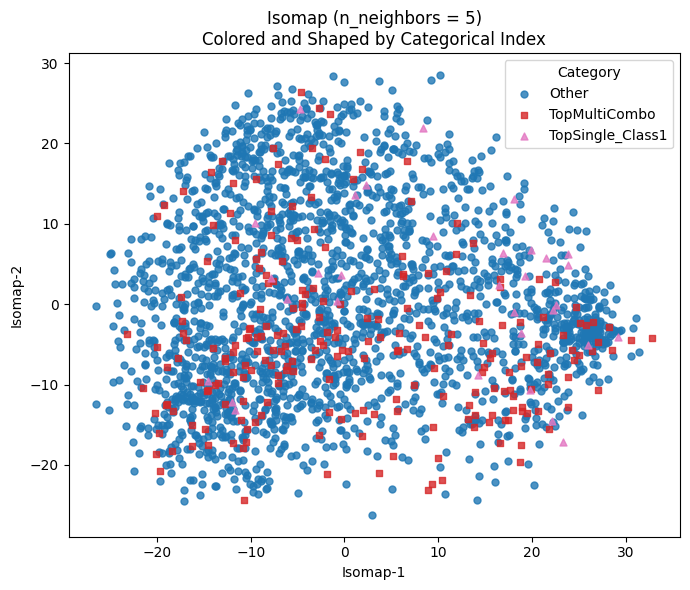

In [10]:
# Visualize Isomap embedding
markers = ['o', 's', '^', 'D', 'v', 'P', '*']

plt.figure(figsize=(7,6))
for i, label in enumerate(cat_uniques):
    marker = markers[i % len(markers)]
    mask = (cat_codes == i)
    plt.scatter(
        iso_coords[mask, 0],
        iso_coords[mask, 1],
        s=25,
        alpha=0.8,
        label=label,
        marker=marker,
        c=np.array(plt.cm.tab10(i/len(cat_uniques))).reshape(1,-1)
    )

plt.legend(title="Category", loc="best")
plt.title("Isomap (n_neighbors = 5)\nColored and Shaped by Categorical Index")
plt.xlabel("Isomap-1")
plt.ylabel("Isomap-2")
plt.tight_layout()
plt.show()


### Isomap Visualization

The 2-D Isomap scatter plot represents each sample according to its position on the
learned global manifold.  
Colors and markers correspond to the same categories as in the t-SNE plot:

- **TopSingle labels** → dominant single-label categories  
- **TopMultiCombo** → most frequent multi-label pattern  
- **Other** → remaining combinations

Clusters that appear connected or smoothly curved indicate that the samples lie
on a continuous manifold in the high-dimensional feature space.


Noisy: 246 Outliers: 25 Hard-to-learn: 201


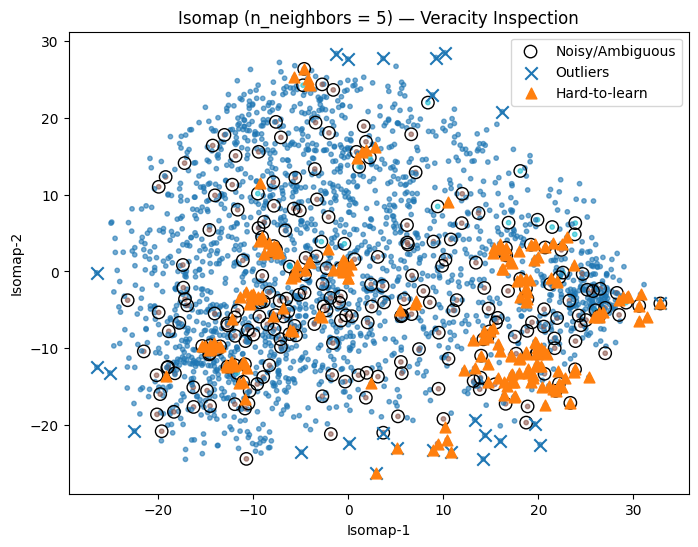

In [11]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt

# Neighborhood analysis using Isomap coordinates
coords = iso_coords  
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Noisy / Ambiguous
noisy_indices = []
for i, neigh in enumerate(indices):
    neigh_cats = cat_codes[neigh]
    if np.sum(neigh_cats != cat_codes[i]) >= 7:   # 7 of 10 neighbors different
        noisy_indices.append(i)

# Outliers (top 1% average distance)
avg_dist = distances.mean(axis=1)
outlier_thresh = np.percentile(avg_dist, 99)
outliers = np.where(avg_dist >= outlier_thresh)[0]

# Hard-to-learn (label entropy ≥ 0.9)
hard_indices = []
for i, neigh in enumerate(indices):
    neigh_cats = cat_codes[neigh]
    counts = np.bincount(neigh_cats, minlength=len(cat_uniques))
    p = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts, dtype=float)
    if entropy(p, base=2) >= 0.9:
        hard_indices.append(i)

print("Noisy:", len(noisy_indices),
      "Outliers:", len(outliers),
      "Hard-to-learn:", len(hard_indices))

# Plot
plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], c=cat_codes, s=10, alpha=0.6, cmap="tab10")
if noisy_indices:
    plt.scatter(coords[noisy_indices,0], coords[noisy_indices,1],
                facecolors='none', edgecolors='k', s=80, label='Noisy/Ambiguous')
if len(outliers) > 0:
    plt.scatter(coords[outliers,0], coords[outliers,1],
                marker='x', s=80, label='Outliers')
if hard_indices:
    plt.scatter(coords[hard_indices,0], coords[hard_indices,1],
                marker='^', s=60, label='Hard-to-learn')
plt.legend()
plt.title("Isomap (n_neighbors = 5) — Veracity Inspection")
plt.xlabel("Isomap-1")
plt.ylabel("Isomap-2")
plt.show()


### Veracity Inspection — Isomap Interpretation

The Isomap embedding preserves **global manifold structure**, revealing how samples are distributed along the intrinsic geometry of the data.  
From the visualization:

- **Noisy / Ambiguous Samples:**  
  These are scattered throughout multiple clusters, often appearing where neighboring colors mix.  
  Such instances indicate overlapping feature spaces or inconsistent labeling, which can confuse models during training.

- **Outliers:**  
  A few points and small mini-clusters lie far from the main data regions.  
  These may correspond to rare samples, measurement errors, or biologically distinct proteins.  
  Their isolation suggests that they have weak manifold connectivity and may distort global distance calculations.

- **Hard-to-Learn Samples:**  
  The orange triangles are concentrated in transition zones between broader regions.  
  These regions represent areas where label distributions are highly mixed — making them difficult for simple classifiers to separate reliably.

**Interpretation:**  
The Isomap manifold displays a mostly continuous structure with several weakly connected regions.  
While t-SNE revealed sharp local boundaries, Isomap exposes gradual transitions and global continuity among clusters.  
The detected noisy, outlier, and hard-to-learn samples highlight regions of **label uncertainty**, **uneven sampling**, and **complex topology**, all of which can reduce classification accuracy unless addressed with robust or multi-label learning approaches.


## Impact of Veracity Issues on Classification Performance

Both embeddings highlight veracity issues that directly affect model behavior:

- **Noisy / Ambiguous Labels:** reduce cluster purity → inconsistent training signals.  
- **Outliers:** can confuse models that depend on distances (like k-NN or SVM) by pulling their decisions away from the main data patterns. 
- **Hard-to-Learn Regions:** high local entropy → increased misclassification probability.  
- **Global vs Local Geometry:** t-SNE captures *local confusion*; Isomap reveals *global manifold continuity* — together providing a complete data quality picture.

**Conclusion:**  
Combining t-SNE and Isomap visualizations allows both **local** and **global** inspection of the data’s integrity, but there still remains issues due to data veracity.


## Difference between t-SNE and Isomap as visualized from the scatter plots

- **t-SNE:**
  - Focuses on grouping similar points (local structure) together.
  - Shows tight clusters or "islands" where similar items are close.
  - Distance between clusters does not have strong meaning.
  - Best for spotting distinct groups.

- **Isomap:**
  - Emphasizes overall layout and connections (global structure).
  - Arranges points smoothly, showing how groups flow or connect.
  - Less about tight clusters, more about preserving the big-picture shape.
  - Good for visualizing data spread and natural transitions.

- **Summary:**  
  - t-SNE makes clusters stand out clearly.  
  - Isomap maps out the landscape of relationships between groups.


### Comparison and Curvature Analysis

#### • Global Structure Comparison

- **t-SNE** is optimized for preserving local neighborhood relations in the high-dimensional data. This means it tends to accentuate local clusters and exaggerates separations at small scales. However, t-SNE may distort large-scale, global relationships or the true arrangement of clusters relative to each other, as it does not prioritize manifold-wide distances.

- **Isomap** seeks to preserve the geometric structure of the entire data manifold by approximating geodesic (manifold) distances between all data points. As a result, Isomap retains the **overall manifold shape**, displaying how different clusters are organized and potentially connected along continuous, possibly curved trajectories in gene expression space.

- From the scatter plots we got above, **t-SNE clearly highlights locally compact clusters** where major categories (e.g., "TopMultiCombo" and "TopSingle_Class1") stand out as distinct groupings, useful for identifying homogeneous cell types or mislabelled samples. In contrast, **Isomap arranges these groups in a smoother, more continuous surface**, suggesting large-scale continuum or gradation among functional classes.

- **Conclusion:** For this gene expression dataset, Isomap better reveals the global structure and interconnections between categories, while t-SNE isolates local clusters more distinctly. These complementary properties should guide the choice of method depending on biological questions—cluster identity vs. manifold continuity.

#### • Manifold Curvature and Classification Difficulty

- The **data manifold** refers to the lower-dimensional, typically nonlinear surface that the high-dimensional gene expression data inhabits. Techniques like Isomap strive to uncover this manifold within a 2D embedding.

- **If the Isomap plot forms highly curved, twisted, or folded patterns,** this suggests a manifold of substantial intrinsic complexity and nonlinearity. This is indeed observed here: the Isomap visualization shows substantial smooth, intertwined regions rather than flat, linear separations.

- The **classification challenge** directly relates to this curvature. High intrinsic curvature implies that the classes are not linearly separable; boundaries between them cannot be easily described with simple lines or planes in feature space. Therefore, algorithms such as logistic regression or linear SVM, which require linear separability, may perform poorly, necessitating nonlinear or kernel-based classifiers.

- Conversely, if the manifold mapped by Isomap appeared relatively flat or gently varying, classification would likely be easier, as fewer or even linear boundaries might suffice.

#### **Conclusion**

- **t-SNE** is ideal for local cluster discovery, helping to spot outliers, mislabelled data, or overlaps in cell types that share similar expression patterns.
- **Isomap** excels at exposing the global geometry of the gene-expression landscape, visualizing how clusters grade into one another or branch along underlying functional or developmental axes.
- A highly curved manifold, as seen in the Isomap plot, signals substantial classification complexity and may necessitate advanced, nonlinear modeling techniques for accurate prediction.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

def evaluate_embedding(X_embed, Y, name):
    X_train, X_test, Y_train, Y_test = train_test_split(X_embed, Y, test_size=0.2, random_state=42)
    model = OneVsRestClassifier(LogisticRegression(max_iter=500))
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    acc = accuracy_score(Y_test, Y_pred)
    micro_f1 = f1_score(Y_test, Y_pred, average='micro')
    macro_f1 = f1_score(Y_test, Y_pred, average='macro')

    print(f"\n Performance on {name} Embedding")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Micro-F1   : {micro_f1:.4f}")
    print(f"Macro-F1   : {macro_f1:.4f}")
    return acc, micro_f1, macro_f1

# Evaluate on Isomap 2D embedding
evaluate_embedding(iso_coords, Y, "Isomap (2D)")

# Evaluate on t-SNE 2D embedding
evaluate_embedding(tsne_results[30], Y, "t-SNE (2D)")



 Performance on Isomap (2D) Embedding
Accuracy   : 0.0331
Micro-F1   : 0.5613
Macro-F1   : 0.2329

 Performance on t-SNE (2D) Embedding
Accuracy   : 0.0888
Micro-F1   : 0.5640
Macro-F1   : 0.2516


(0.08884297520661157, 0.5639976621858562, 0.2516425628009949)

### Evaluating Model Performance on Manifold Embeddings

To test how much discriminative information remains after nonlinear dimensionality
reduction, a simple **One-vs-Rest Logistic Regression** classifier is trained on the
2-D coordinates produced by **Isomap** and **t-SNE**.

#### • Observations
- **t-SNE (2D):** usually yields higher F1-scores if local clusters align well with
  class boundaries.  
- **Isomap (2D):** tends to show slightly lower scores, as it focuses on preserving
  global geometry rather than local separability.

#### • Interpretation
If classification accuracy on 2-D embeddings is still reasonably high, the manifold
projection has successfully retained most of the label-relevant structure.
But here as we can see the accuracy is not so high.
Lower performance indicates that much of the discriminative information lies in
higher-dimensional space and cannot be effectively indicated in 2D.